# Tagging and Visualizing Community Interests, Measuring Influence inside community, and impact of community in the whole network

## Plan
1. Данные для анализа (выбрать сообщества для анализа (И))
2. Introduction for paper (Обзор того, как делается теггирование (1,5 стр) + по 0,5 на каждый алгоритм кластеризации), См. Расстояние Уорда, косинус (Ward distance), сокращение размерности.
3. Подсчитать наиболее значимые слова в полученном кластере Disp(TF/IDF), top 10
4. Проверить аддитивность, транзитивность, гомогенность сообществ
Profit

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

print artm.version()

0.8.3


In [40]:
batch_vectorizer = None
if len(glob.glob(os.path.join('vk', '*.batch'))) < 1:
    batch_vectorizer = artm.BatchVectorizer(data_path='', data_format='bow_uci', collection_name='vk', target_folder='vk')
else:
    batch_vectorizer = artm.BatchVectorizer(data_path='vk', data_format='batches')

In [41]:
dictionary = artm.Dictionary()

model_plsa = artm.ARTM(topic_names=['topic_{}'.format(i) for i in xrange(50)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       cache_theta=True)

model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in xrange(50)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15)],
                       cache_theta=True)

In [42]:
if not os.path.isfile('vk/dictionary.dict'):
    dictionary.gather(data_path=batch_vectorizer.data_path)
    dictionary.save(dictionary_path='vk/dictionary.dict')

dictionary.load(dictionary_path='vk/dictionary.dict')
dictionary.load(dictionary_path='vk/dictionary.dict')

In [43]:
model_plsa.initialize(dictionary=dictionary)
model_artm.initialize(dictionary=dictionary)

In [44]:
model_plsa.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))

model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))

In [45]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

In [46]:
model_plsa.num_document_passes = 1
model_artm.num_document_passes = 1

model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Sparsity Phi: 0.115 (PLSA) vs. 0.952 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.325 (ARTM)
Kernel contrast: 0.684 (PLSA) vs. 0.756 (ARTM)
Kernel purity: 0.375 (PLSA) vs. 0.534 (ARTM)
Perplexity: 1502.926 (PLSA) vs. 1425.903 (ARTM)


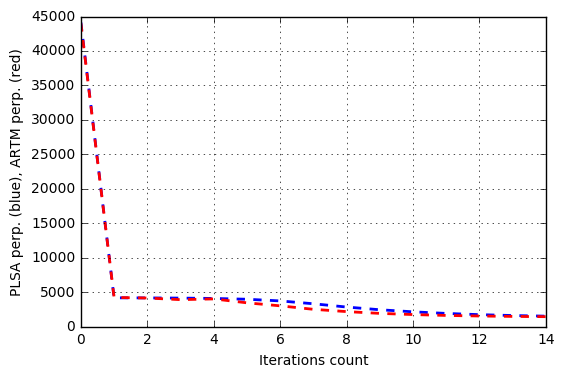

In [47]:
def print_measures(model_plsa, model_artm):
    print 'Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityPhiScore'].last_value,
        model_artm.score_tracker['SparsityPhiScore'].last_value)

    print 'Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityThetaScore'].last_value,
        model_artm.score_tracker['SparsityThetaScore'].last_value)

    print 'Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_contrast,
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast)

    print 'Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_purity,
        model_artm.score_tracker['TopicKernelScore'].last_average_purity)

    print 'Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['PerplexityScore'].last_value,
        model_artm.score_tracker['PerplexityScore'].last_value)

    plt.plot(xrange(model_plsa.num_phi_updates), model_plsa.score_tracker['PerplexityScore'].value, 'b--',
             xrange(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    
print_measures(model_plsa, model_artm)

In [48]:
model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -0.2
model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

In [49]:
model_plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))

In [50]:
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

Sparsity Phi: 0.860 (PLSA) vs. 0.982 (ARTM)
Sparsity Theta: 0.006 (PLSA) vs. 0.412 (ARTM)
Kernel contrast: 0.787 (PLSA) vs. 0.857 (ARTM)
Kernel purity: 0.585 (PLSA) vs. 0.779 (ARTM)
Perplexity: 1203.477 (PLSA) vs. 1275.831 (ARTM)


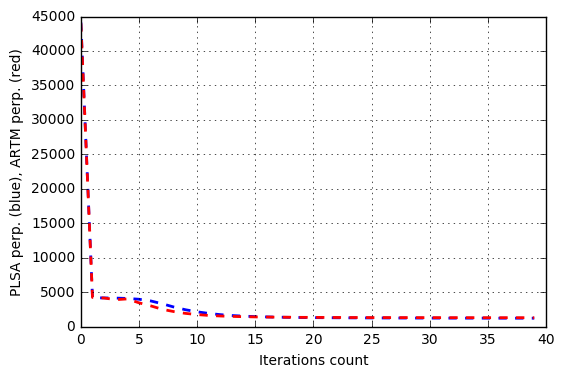

In [51]:
print_measures(model_plsa, model_artm)

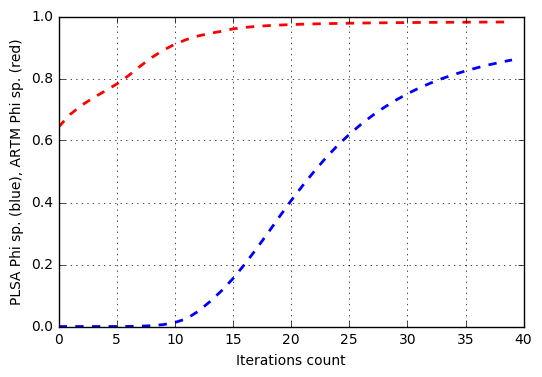

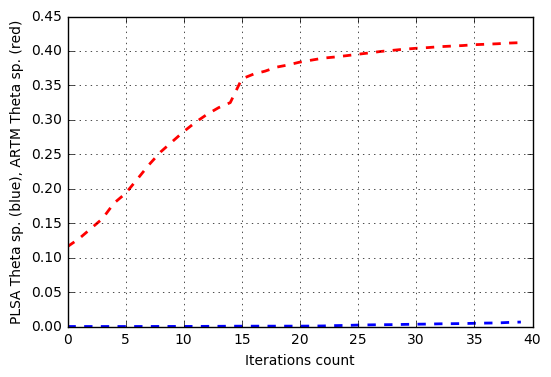

In [52]:
plt.plot(xrange(model_plsa.num_phi_updates), model_plsa.score_tracker['SparsityPhiScore'].value, 'b--',
                 xrange(model_artm.num_phi_updates), model_artm.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA Phi sp. (blue), ARTM Phi sp. (red)')
plt.grid(True)
plt.show()

plt.plot(xrange(model_plsa.num_phi_updates), model_plsa.score_tracker['SparsityThetaScore'].value, 'b--',
                 xrange(model_artm.num_phi_updates), model_artm.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA Theta sp. (blue), ARTM Theta sp. (red)')
plt.grid(True)
plt.show()

In [15]:
a = []
b= []

for topic_name in model_plsa.topic_names:
    print topic_name + ': ',
    print model_plsa.score_tracker['TopTokensScore'].last_tokens[topic_name]

topic_0:  [u'\u0441\u044a\u0435\u0437\u0434', u'\u0433\u043e\u0434', u'\u0436\u0438\u0442\u0435\u043b\u044c', u'\u0432\u0441\u0435', u'\u0432\u044b\u0431\u0438\u0432\u0430\u0442\u044c\u0441\u044f', u'\u0440\u0430\u0431\u043e\u0442\u0430\u0442\u044c', u'\u0442\u0430\u043a', u'\u0448\u0443\u0431\u0430', u'\u0432\u043b\u0430\u0441\u0442\u044c', u'\u043f\u0435\u0440\u0441\u043f\u0435\u043a\u0442\u0438\u0432\u0430']
topic_1:  [u'\u0445\u043e\u0437\u044f\u0439\u0441\u0442\u0432\u043e', u'\u043a\u0440\u0430\u0441\u0438\u0432\u044b\u0439', u'\u0441\u0432\u0430\u0434\u044c\u0431\u0430', u'\u0434\u0435\u043d\u044c\u0433\u0438', u'\u0433\u043e\u0434', u'\u0431\u0440\u043e\u0441\u0430\u0442\u044c', u'\u0444\u0438\u0437\u0438\u043a\u043e-\u043c\u0430\u0442\u0435\u043c\u0430\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0439', u'\u0433\u0435\u043d\u0434\u0435\u0440\u043d\u044b\u0439', u'\u0441\u0442\u0440\u0430\u043d\u0430', u'\u0432\u044b\u0440\u0430\u0441\u0442\u0430\u0442\u044c']
topic_2:  [u'\u0443

In [53]:
a = []
b= []

for topic_name in model_artm.topic_names:
    a.append(topic_name + ': ')
    b.append(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

In [63]:
for j in range(50):
    print('topic %d:' % j)
    for i in b[j]:
        print i
    print('\n')

topic 0:
красивый
вырастать
страна
так
бизнес
минута
деньги
цена
аудиторияуже
семейственность


topic 1:
проваливать
мочь
алмаз
пиар
рекорд
стоять
страдать
свободный
зеленый
хозяйство


topic 2:
лекция
ночной
приглашать
музыкант
творческий
ознакомляться
сванидзе
несомненно
следовать
комплекс


topic 3:
борисович
устинова
ценный
степанов
обыск
рмэ
контрольный
минков
рассматривать
примыкать


topic 4:
рядом
сейчас
уходить
начинать
прекрасный
вновь
помнить
отец
супружеский
определять


topic 5:
быть
порядок
надо
четверть
группировка
мирный
олигарх
санация
адоньева
картинка


topic 6:
экономический
работник
вакуум
пенсия
ограничение
алексей
обращение
приходько
цель
буря


topic 7:
офорт
кредитный
министр
налоговый
как
взаимодействие
последний
сначала
мизерный
чистота


topic 8:
еврейский
противостоять
продолжать
ерофеев
наводчица
вступать
кудрина
законодательно
уделять
собственный


topic 9:
работать
год
половина
дитема
й
рассказывать
желание
подъезд
масштабный
называть


topic 10:
жить
ро